In [1]:
from imap_functions import *
import matplotlib.pyplot as plt

HAPI version: 1.1.0.9.4
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


# Test 1 - CM Expected (25 SZA, 25% reflectance, 5nm SSD, 6nm FWHM)

In [88]:

##### EXAMPLE RETRIEVAL FOR SCENE OVER SAN JUAN POWER PLANT


#Load data
class args:
    pass

args.direc = 'ang20190621t194713_rdn_v2u1_img_SanJuanMethane'
args.name = 'ang20190621t194713_rdn_v2u1_img_SanJuanMethane'
args.lat = 36.793
args.lon = 108.391
args.source = 'SanJuanMethane'
args.met = 'ang20190621t194713_rdn_v2u1_img_SanJuanMethane'
args.hitran = 'ang20190621t194713_rdn_v2u1_img_SanJuanMethane'
args.met = 'prs20191115t171641_Blowout'
args.hitran = 'prs20191115t171641_Blowout'


#Set up the retrieval
init_dict = {'rad_dir': args.direc,\
             'rad_name': args.name,\
             'main': '/Users/cusworth/Documents/IMAP_DOAS/input/',\
             'wave_pos': 'ancillary/CM_expected_wvl_aa.txt',\
             'alt_agl_km': 410,\
             'latitude': float(args.lat),\
             'longitude': -1*float(args.lon),\
             'fwhm': 6,\
             'SNR': 700,\
             'deg_poly': 4,\
             'do_legendre': True, \
             'met_file':'met/merra_met'+ args.met + '.p',\
             'inversion_wvl': [2210, 2420], \
             'hitran_loaded': args.hitran}



#Load image and data
files, set_inputs, wave_class, set_flight, coord_sub = initialize(init_dict)
met = load_met(set_inputs, set_flight, files)
cs, met, wave_class = load_hitran_solar(wave_class, met, files)
rgb, rad_sub, wave_class, met = load_raw_observations(files, set_inputs, wave_class, met, cs)

#Need to hack SZA
met.SZA = 25

# load in referenace spectrum and assign it to Y_ref
df = pd.read_csv('ancillary/CM_expected_df.csv')
wvl_df = df.wvl
Y_df= df.ref_rad
Y_sel = (wvl_df >= wave_class.inversion_wvl[0]) & (wvl_df <= wave_class.inversion_wvl[1])
Y_lo = Y_df[Y_sel]
Y_ref = pd.DataFrame.to_numpy(Y_lo)


In [89]:
#Big hack for new abs cross sections
imet = pd.read_csv('met/Z_P_T_Modtran.csv')
met.pmid = sp.interpolate.interp1d(imet.Z, imet.P)(met.zmid)
met.Tmid = sp.interpolate.interp1d(imet.Z, imet['T'])(met.zmid)

if False:
    file_name = 'prec_test'

    HWVL_max = 10000000 / wave_class.hitran_wvl[0]
    HWVL_min = 10000000 / wave_class.hitran_wvl[1]

    #Load Hitran gas tables
    fetch('hitran/H2O' + file_name , 1, 1, HWVL_min, HWVL_max )
    fetch('hitran/CH4' + file_name, 6, 1, HWVL_min, HWVL_max )
    fetch('hitran/N2O' + file_name, 4, 1, HWVL_min, HWVL_max )


    #Use Hapi to compute cross sections at each level in the atmosphere
    for i in range(len(pmids)):
        p_ = met.pmid[i]/1013. 
        T_ = met.Tmid[i]      
        nu_, cs_h2o = absorptionCoefficient_Voigt(((1,1),), \
                                                  WavenumberRange=[HWVL_min,HWVL_max], \
                                                  Environment={'p':p_,'T':T_}, \
                                                  WavenumberStep=0.04)
        nu_, cs_ch4 = absorptionCoefficient_Voigt(((6,1),), \
                                                  WavenumberRange=[HWVL_min,HWVL_max], \
                                                  Environment={'p':p_,'T':T_}, \
                                                  WavenumberStep=0.04)
        nu_, cs_n2o = absorptionCoefficient_Voigt(((4,1),), \
                                                  WavenumberRange=[HWVL_min,HWVL_max], \
                                                  Environment={'p':p_,'T':T_}, \
                                                  WavenumberStep=0.04)
        if i == 0:
            cs_matrix_h2o = np.zeros((len(nu_), len(met.pmid)))
            cs_matrix_ch4 = np.zeros((len(nu_), len(met.pmid)))
            cs_matrix_n2o = np.zeros((len(nu_), len(met.pmid)))

        cs_matrix_h2o[:,i] = cs_h2o
        cs_matrix_ch4[:,i] = cs_ch4
        cs_matrix_n2o[:,i] = cs_n2o

        print(i, 'level cross sections done')

    pickle.dump(cs_matrix_h2o, open( 'hitran/cs_matrix_h2o' + file_name + '.p', 'wb' ) )
    pickle.dump(cs_matrix_ch4, open( 'hitran/cs_matrix_ch4' + file_name + '.p', 'wb' ) )
    pickle.dump(cs_matrix_n2o, open( 'hitran/cs_matrix_n2o' + file_name + '.p', 'wb' ) )
    pickle.dump(nu_, open( 'hitran/cs_matrix_nu' + file_name + '.p', 'wb' ) )
    
    

    cs_matrix_h2o = pickle.load( open( 'hitran/cs_matrix_h2o' + file_name + '.p', 'rb' ) )
    cs_matrix_ch4 = pickle.load( open( 'hitran/cs_matrix_ch4' + file_name + '.p', 'rb' ) )
    cs_matrix_n2o = pickle.load( open( 'hitran/cs_matrix_n2o' + file_name + '.p', 'rb' ) )
    nu_ = pickle.load( open( 'hitran/cs_matrix_nu' + file_name + '.p', 'rb' ) )


In [90]:
#Make obs error covariance
snr = df.SNR
nnoise = Y_ref / (snr[Y_sel]**2)
invSe = np.diag(1/nnoise)

In [91]:
### Retrieval equations - in the more operational code, this is called "run_retrieval2"

#~~~~ INDICES IN DATA CUBE TO PLAY AROUND WITH ~~~~~
iindex = 20#(82-67)
jindex =20#21

#Run retrieval given indices
#Y = rad_sub[iindex,jindex,:] / .1
#Y = Y[wave_class.wvl_sel]
## assign T-ref to Y and comment out the code to pul from image
Y = Y_ref

inv_prms = make_class()

#Prior start of polynomial fit is fit to subsample of Y
init_k = set_inputs.deg_poly
YT = Y/met.T_lo_0

hi_x = np.linspace(-1, 1, len(wave_class.wvl_hi))
lo_x = interpolate.interp1d(np.flip(wave_class.wvl_hi), hi_x)(wave_class.wvl_lo)

#Do legendre or normal polynomial
if False:
    near_zeros = np.where(wave_class.cs_low < np.percentile(wave_class.cs_low, 90))[0]
    lfit = np.polynomial.legendre.legfit(lo_x[near_zeros], YT[near_zeros], init_k)
    lval = np.polynomial.legendre.legval(hi_x, lfit)
    lval_lo = np.polynomial.legendre.legval(lo_x, lfit)

else:
    near_zeros = np.where(wave_class.cs_low < np.percentile(wave_class.cs_low, 90))[0]
    lfit = np.polynomial.polynomial.polyfit(lo_x[near_zeros], Y[near_zeros], init_k)
    lval = np.polynomial.polynomial.polyval(hi_x, lfit)
    lval_lo = np.polynomial.polynomial.polyval(lo_x, lfit)

#Scaling factors for gases
lCH4 = set_inputs.layers_ch4
lH2O = set_inputs.layers_h2o
lN2O = set_inputs.layers_n2o

#Define first prior
s1 = get_scaling(met.vmr_CH4, met.ch4_red_A, met.bnd_ch4, met.pmid, met.h_full)
s2 = get_scaling(met.vmr_H2O, met.h2o_red_A, met.bnd_h2o, met.pmid, met.h_full)
s3 = get_scaling(met.vmr_N2O, met.n2o_red_A, met.bnd_n2o, met.pmid, met.h_full)

#Set value of first prior + first iteration
xa_full = np.append(s1, np.append(s2, np.append(s3, np.append(wave_class.shift_coef, lfit))))
inv_prms.xa_full = xa_full

#Construct prior error covariance
sig_prior = np.abs(xa_full)  #Error on prior proportional to magnitude

#Methane prior
sig_prior[0] *= .5
if set_inputs.layers_ch4 == 2: #If airbone
    sig_prior[1] *= .1    
sig_prior[(lCH4):(lCH4+lH2O)] *= .1 #H2O prior
sig_prior[(lCH4+lH2O):(lCH4+lH2O+lN2O)] *= 1e-2 #N2O prior
sig_prior[lCH4+lH2O+lN2O] *= 1e-5 #Shift prior
sig_prior[-len(lfit):] *= 1e-2 #polynomial
Sa = np.diag((sig_prior**2))
invSa = np.linalg.inv(Sa)

#Obs error covariance
#noise_val = 1/(set_inputs.SNR**2)
#invSe = np.diag([1/noise_val] * len(Y))

#Do five iterations - generally this is sufficient
for i_iter in range(5):
    
    if i_iter == 0:
        ix = xa_full
    else:
        ix = x_1

    #Run Forward model
    ilval = np.polynomial.polynomial.polyval(hi_x, ix[-len(lfit):])
    T = np.flip(Transmission(ix[0:(lCH4)], ix[(lCH4):(lCH4+lH2O)], ix[(lCH4+lH2O):(lCH4+lH2O+lN2O)], met, cs))
    Fa = F_lo(Forward3(T, ilval), np.flip(wave_class.wvl_hi), wave_class.wvl_lo, set_inputs.fwhm)
    if i_iter==0:
        Fa_1 = Fa
    
    #Create Jacobian
    K = Make_Jac4(T, lcoefs=ix[-len(lfit):], scoefs=np.array([ix[lCH4+lH2O+lN2O]]), \
            wave_class=wave_class, met=met, set_inputs=set_inputs, cs=cs, \
            sCH4=ix[0:(lCH4)], sH2O=ix[(lCH4):(lCH4+lH2O)], sN2O=ix[(lCH4+lH2O):(lCH4+lH2O+lN2O)])

    #Iterative solution for next state
    term1 = np.linalg.inv(K.T.dot(invSe).dot(K) + invSa)
    term2 = K.T.dot(invSe)
    term3 = (Y - Fa) + K.dot(ix - xa_full)
    x_1 = xa_full + (term1.dot(term2)).dot(term3)

    #Posterior error
    S_1 = np.linalg.inv(K.T.dot(invSe).dot(K)+np.linalg.inv(Sa))
    lval_hat = np.polynomial.polynomial.polyval(hi_x, x_1[-len(lfit):])

#Posterior estimate
sCH4_hat = x_1[0:lCH4]
sH2O_hat = x_1[(lCH4):(lCH4+lH2O)]
sN2O_hat = x_1[(lCH4+lH2O):(lCH4+lH2O+lN2O)]

That = np.flip(Transmission(sCH4_hat, sH2O_hat, sN2O_hat, met, cs))
Fhat = F_lo(Forward3(That, lval_hat), np.flip(wave_class.wvl_hi), wave_class.wvl_lo, set_inputs.fwhm)

#Output data
inv_prms.Fh = Fhat
inv_prms.Y = Y
inv_prms.Fa = Fa_1
inv_prms.RMSE = np.sqrt(np.mean((Y-Fhat)**2))
inv_prms.ilval = lval_lo
inv_prms.lval_hat = F_lo(lval_hat, np.flip(wave_class.wvl_hi), wave_class.wvl_lo, set_inputs.fwhm)
inv_prms.K = K
inv_prms.xhat = x_1
inv_prms.Sa = Sa
inv_prms.Sh = S_1
inv_prms.Aker = np.eye(Sa.shape[0]) - S_1.dot(np.linalg.inv(Sa))
wvl = wave_class.wvl_lo
retrieved_CO2 = (np.dot(x_1[0:lCH4] * met.ch4_red_A, met.h) * 1e9) / 1000


In [92]:
#Show output

print('Retrieval precision (%)', 100*np.sqrt(S_1[0,0]))
print('Prior precision (%)', 100*np.sqrt(Sa[0,0]))
print('Total XCH4 (ppb)', 1000*retrieved_CO2)

Retrieval precision (%) 1.1580908397758887
Prior precision (%) 50.0
Total XCH4 (ppb) 1981.6458616568143


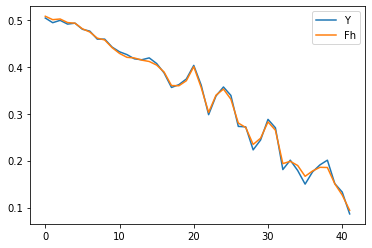

In [93]:
#Plot observed, prior, and posterior spectra

plt.plot(Y, label='Y')
#plt.plot(Fa_1, label='Fa')
plt.plot(Fhat, label='Fh')
plt.legend()
plt.show()


700

# Test 2 - Worst Case (45% albedo, 45 SZA, 6nm SSD, 10nm FWHM)

In [80]:

##### EXAMPLE RETRIEVAL FOR SCENE OVER SAN JUAN POWER PLANT


#Load data
class args:
    pass

args.direc = 'ang20190621t194713_rdn_v2u1_img_SanJuanMethane'
args.name = 'ang20190621t194713_rdn_v2u1_img_SanJuanMethane'
args.lat = 36.793
args.lon = 108.391
args.source = 'SanJuanMethane'
args.met = 'ang20190621t194713_rdn_v2u1_img_SanJuanMethane'
args.hitran = 'ang20190621t194713_rdn_v2u1_img_SanJuanMethane'
args.met = 'prs20191115t171641_Blowout'
args.hitran = 'prs20191115t171641_Blowout'


#Set up the retrieval
init_dict = {'rad_dir': args.direc,\
             'rad_name': args.name,\
             'main': '/Users/cusworth/Documents/IMAP_DOAS/input/',\
             'wave_pos': 'ancillary/CM_worstcase_wvl.txt',\
             'alt_agl_km': 410,\
             'latitude': float(args.lat),\
             'longitude': -1*float(args.lon),\
             'fwhm': 10,\
             'SNR': 700,\
             'deg_poly': 4,\
             'do_legendre': True, \
             'met_file':'met/merra_met'+ args.met + '.p',\
             'inversion_wvl': [2210, 2420], \
             'hitran_loaded': args.hitran}



#Load image and data
files, set_inputs, wave_class, set_flight, coord_sub = initialize(init_dict)
met = load_met(set_inputs, set_flight, files)
cs, met, wave_class = load_hitran_solar(wave_class, met, files)
rgb, rad_sub, wave_class, met = load_raw_observations(files, set_inputs, wave_class, met, cs)

met.SZA=45

# load in referenace spectrum and assign it to Y_ref
df = pd.read_csv('ancillary/CM_worstcase_df.csv')
wvl_df = df.wvl
Y_df= df.ref_rad
Y_sel = (wvl_df >= wave_class.inversion_wvl[0]) & (wvl_df <= wave_class.inversion_wvl[1])
Y_lo = Y_df[Y_sel]
Y_ref = pd.DataFrame.to_numpy(Y_lo)


In [81]:
#Make obs error covariance
snr = df.SNR
nnoise = Y_ref / (snr[Y_sel]**2)
invSe = np.diag(1/nnoise)

In [85]:
### Retrieval equations - in the more operational code, this is called "run_retrieval2"

#~~~~ INDICES IN DATA CUBE TO PLAY AROUND WITH ~~~~~
iindex = 20#(82-67)
jindex =20#21

#Run retrieval given indices
#Y = rad_sub[iindex,jindex,:] / .1
#Y = Y[wave_class.wvl_sel]
## assign T-ref to Y and comment out the code to pul from image
Y = Y_ref

inv_prms = make_class()

#Prior start of polynomial fit is fit to subsample of Y
init_k = set_inputs.deg_poly
YT = Y/met.T_lo_0

hi_x = np.linspace(-1, 1, len(wave_class.wvl_hi))
lo_x = interpolate.interp1d(np.flip(wave_class.wvl_hi), hi_x)(wave_class.wvl_lo)

#Do legendre or normal polynomial
if False:
    near_zeros = np.where(wave_class.cs_low < np.percentile(wave_class.cs_low, 90))[0]
    lfit = np.polynomial.legendre.legfit(lo_x[near_zeros], YT[near_zeros], init_k)
    lval = np.polynomial.legendre.legval(hi_x, lfit)
    lval_lo = np.polynomial.legendre.legval(lo_x, lfit)

else:
    near_zeros = np.where(wave_class.cs_low < np.percentile(wave_class.cs_low, 90))[0]
    lfit = np.polynomial.polynomial.polyfit(lo_x[near_zeros], Y[near_zeros], init_k)
    lval = np.polynomial.polynomial.polyval(hi_x, lfit)
    lval_lo = np.polynomial.polynomial.polyval(lo_x, lfit)

#Scaling factors for gases
lCH4 = set_inputs.layers_ch4
lH2O = set_inputs.layers_h2o
lN2O = set_inputs.layers_n2o

#Define first prior
s1 = get_scaling(met.vmr_CH4, met.ch4_red_A, met.bnd_ch4, met.pmid, met.h_full)
s2 = get_scaling(met.vmr_H2O, met.h2o_red_A, met.bnd_h2o, met.pmid, met.h_full)
s3 = get_scaling(met.vmr_N2O, met.n2o_red_A, met.bnd_n2o, met.pmid, met.h_full)

#Set value of first prior + first iteration
xa_full = np.append(s1, np.append(s2, np.append(s3, np.append(wave_class.shift_coef, lfit))))
inv_prms.xa_full = xa_full

#Construct prior error covariance
sig_prior = np.abs(xa_full)  #Error on prior proportional to magnitude

#Methane prior
sig_prior[0] *= .5
if set_inputs.layers_ch4 == 2: #If airbone
    sig_prior[1] *= .1    
sig_prior[(lCH4):(lCH4+lH2O)] *= .1 #H2O prior
sig_prior[(lCH4+lH2O):(lCH4+lH2O+lN2O)] *= 1e-2 #N2O prior
sig_prior[lCH4+lH2O+lN2O] *= 1e-5 #Shift prior
sig_prior[-len(lfit):] *= 1e-2 #polynomial
Sa = np.diag((sig_prior**2))
invSa = np.linalg.inv(Sa)

#Obs error covariance
#noise_val = 1/(set_inputs.SNR**2)
#invSe = np.diag([1/noise_val] * len(Y))

#Do five iterations - generally this is sufficient
for i_iter in range(5):
    
    if i_iter == 0:
        ix = xa_full
    else:
        ix = x_1

    #Run Forward model
    ilval = np.polynomial.polynomial.polyval(hi_x, ix[-len(lfit):])
    T = np.flip(Transmission(ix[0:(lCH4)], ix[(lCH4):(lCH4+lH2O)], ix[(lCH4+lH2O):(lCH4+lH2O+lN2O)], met, cs))
    Fa = F_lo(Forward3(T, ilval), np.flip(wave_class.wvl_hi), wave_class.wvl_lo, set_inputs.fwhm)
    if i_iter==0:
        Fa_1 = Fa
    
    #Create Jacobian
    K = Make_Jac4(T, lcoefs=ix[-len(lfit):], scoefs=np.array([ix[lCH4+lH2O+lN2O]]), \
            wave_class=wave_class, met=met, set_inputs=set_inputs, cs=cs, \
            sCH4=ix[0:(lCH4)], sH2O=ix[(lCH4):(lCH4+lH2O)], sN2O=ix[(lCH4+lH2O):(lCH4+lH2O+lN2O)])

    #Iterative solution for next state
    term1 = np.linalg.inv(K.T.dot(invSe).dot(K) + invSa)
    term2 = K.T.dot(invSe)
    term3 = (Y - Fa) + K.dot(ix - xa_full)
    x_1 = xa_full + (term1.dot(term2)).dot(term3)

    #Posterior error
    S_1 = np.linalg.inv(K.T.dot(invSe).dot(K)+np.linalg.inv(Sa))
    lval_hat = np.polynomial.polynomial.polyval(hi_x, x_1[-len(lfit):])

#Posterior estimate
sCH4_hat = x_1[0:lCH4]
sH2O_hat = x_1[(lCH4):(lCH4+lH2O)]
sN2O_hat = x_1[(lCH4+lH2O):(lCH4+lH2O+lN2O)]

That = np.flip(Transmission(sCH4_hat, sH2O_hat, sN2O_hat, met, cs))
Fhat = F_lo(Forward3(That, lval_hat), np.flip(wave_class.wvl_hi), wave_class.wvl_lo, set_inputs.fwhm)

#Output data
inv_prms.Fh = Fhat
inv_prms.Y = Y
inv_prms.Fa = Fa_1
inv_prms.RMSE = np.sqrt(np.mean((Y-Fhat)**2))
inv_prms.ilval = lval_lo
inv_prms.lval_hat = F_lo(lval_hat, np.flip(wave_class.wvl_hi), wave_class.wvl_lo, set_inputs.fwhm)
inv_prms.K = K
inv_prms.xhat = x_1
inv_prms.Sa = Sa
inv_prms.Sh = S_1
inv_prms.Aker = np.eye(Sa.shape[0]) - S_1.dot(np.linalg.inv(Sa))
wvl = wave_class.wvl_lo
retrieved_CO2 = (np.dot(x_1[0:lCH4] * met.ch4_red_A, met.h) * 1e9) / 1000


In [86]:
#Show output

print('Retrieval precision (%)', 100*np.sqrt(S_1[0,0]))
print('Prior precision (%)', 100*np.sqrt(Sa[0,0]))
print('Total XCH4 (ppb)', 1000*retrieved_CO2)

Retrieval precision (%) 2.1732811820514435
Prior precision (%) 50.0
Total XCH4 (ppb) 1219.51532441424


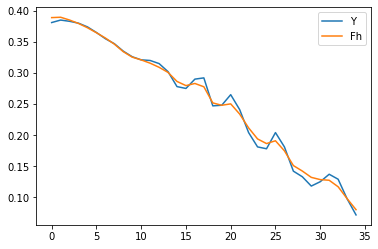

In [87]:
#Plot observed, prior, and posterior spectra

plt.plot(Y, label='Y')
#plt.plot(Fa_1, label='Fa')
plt.plot(Fhat, label='Fh')
plt.legend()
plt.show()

# JPL Reference Case (25% albedo, 45 SZA, 5nm SSD, 6 nm FWHM)

In [72]:

##### EXAMPLE RETRIEVAL FOR SCENE OVER SAN JUAN POWER PLANT


#Load data
class args:
    pass

args.direc = 'ang20190621t194713_rdn_v2u1_img_SanJuanMethane'
args.name = 'ang20190621t194713_rdn_v2u1_img_SanJuanMethane'
args.lat = 36.793
args.lon = 108.391
args.source = 'SanJuanMethane'
args.met = 'ang20190621t194713_rdn_v2u1_img_SanJuanMethane'
args.hitran = 'ang20190621t194713_rdn_v2u1_img_SanJuanMethane'
args.met = 'prs20191115t171641_Blowout'
args.hitran = 'prs20191115t171641_Blowout'


#Set up the retrieval
init_dict = {'rad_dir': args.direc,\
             'rad_name': args.name,\
             'main': '/Users/cusworth/Documents/IMAP_DOAS/input/',\
             'wave_pos': 'ancillary/CM_expected_wvl.txt',\
             'alt_agl_km': 410,\
             'latitude': float(args.lat),\
             'longitude': -1*float(args.lon),\
             'fwhm': 6,\
             'SNR': 700,\
             'deg_poly': 4,\
             'do_legendre': True, \
             'met_file':'met/merra_met'+ args.met + '.p',\
             'inversion_wvl': [2210, 2420], \
             'hitran_loaded': args.hitran}



#Load image and data
files, set_inputs, wave_class, set_flight, coord_sub = initialize(init_dict)
met = load_met(set_inputs, set_flight, files)
cs, met, wave_class = load_hitran_solar(wave_class, met, files)
rgb, rad_sub, wave_class, met = load_raw_observations(files, set_inputs, wave_class, met, cs)

met.SZA = 45

# load in referenace spectrum and assign it to Y_ref
df = pd.read_csv('ancillary/CM_JPL_df.csv')
wvl_df = df.wvl
Y_df= df.ref_rad
Y_sel = (wvl_df >= wave_class.inversion_wvl[0]) & (wvl_df <= wave_class.inversion_wvl[1])
Y_lo = Y_df[Y_sel]
Y_ref = pd.DataFrame.to_numpy(Y_lo)


In [73]:
#Make obs error covariance
snr = df.SNR
nnoise = Y_ref / (snr[Y_sel]**2)
invSe = np.diag(1/nnoise)

In [74]:
### Retrieval equations - in the more operational code, this is called "run_retrieval2"

#~~~~ INDICES IN DATA CUBE TO PLAY AROUND WITH ~~~~~
iindex = 20#(82-67)
jindex =20#21

#Run retrieval given indices
#Y = rad_sub[iindex,jindex,:] / .1
#Y = Y[wave_class.wvl_sel]
## assign T-ref to Y and comment out the code to pul from image
Y = Y_ref

inv_prms = make_class()

#Prior start of polynomial fit is fit to subsample of Y
init_k = set_inputs.deg_poly
YT = Y/met.T_lo_0

hi_x = np.linspace(-1, 1, len(wave_class.wvl_hi))
lo_x = interpolate.interp1d(np.flip(wave_class.wvl_hi), hi_x)(wave_class.wvl_lo)

#Do legendre or normal polynomial
if False:
    near_zeros = np.where(wave_class.cs_low < np.percentile(wave_class.cs_low, 90))[0]
    lfit = np.polynomial.legendre.legfit(lo_x[near_zeros], YT[near_zeros], init_k)
    lval = np.polynomial.legendre.legval(hi_x, lfit)
    lval_lo = np.polynomial.legendre.legval(lo_x, lfit)

else:
    near_zeros = np.where(wave_class.cs_low < np.percentile(wave_class.cs_low, 90))[0]
    lfit = np.polynomial.polynomial.polyfit(lo_x[near_zeros], Y[near_zeros], init_k)
    lval = np.polynomial.polynomial.polyval(hi_x, lfit)
    lval_lo = np.polynomial.polynomial.polyval(lo_x, lfit)

#Scaling factors for gases
lCH4 = set_inputs.layers_ch4
lH2O = set_inputs.layers_h2o
lN2O = set_inputs.layers_n2o

#Define first prior
s1 = get_scaling(met.vmr_CH4, met.ch4_red_A, met.bnd_ch4, met.pmid, met.h_full)
s2 = get_scaling(met.vmr_H2O, met.h2o_red_A, met.bnd_h2o, met.pmid, met.h_full)
s3 = get_scaling(met.vmr_N2O, met.n2o_red_A, met.bnd_n2o, met.pmid, met.h_full)

#Set value of first prior + first iteration
xa_full = np.append(s1, np.append(s2, np.append(s3, np.append(wave_class.shift_coef, lfit))))
inv_prms.xa_full = xa_full

#Construct prior error covariance
sig_prior = np.abs(xa_full)  #Error on prior proportional to magnitude

#Methane prior
sig_prior[0] *= .5
if set_inputs.layers_ch4 == 2: #If airbone
    sig_prior[1] *= .1    
sig_prior[(lCH4):(lCH4+lH2O)] *= .1 #H2O prior
sig_prior[(lCH4+lH2O):(lCH4+lH2O+lN2O)] *= 1e-2 #N2O prior
sig_prior[lCH4+lH2O+lN2O] *= 1e-5 #Shift prior
sig_prior[-len(lfit):] *= 1e-2 #polynomial
Sa = np.diag((sig_prior**2))
invSa = np.linalg.inv(Sa)

#Obs error covariance
#noise_val = 1/(set_inputs.SNR**2)
#invSe = np.diag([1/noise_val] * len(Y))

#Do five iterations - generally this is sufficient
for i_iter in range(5):
    
    if i_iter == 0:
        ix = xa_full
    else:
        ix = x_1

    #Run Forward model
    ilval = np.polynomial.polynomial.polyval(hi_x, ix[-len(lfit):])
    T = np.flip(Transmission(ix[0:(lCH4)], ix[(lCH4):(lCH4+lH2O)], ix[(lCH4+lH2O):(lCH4+lH2O+lN2O)], met, cs))
    Fa = F_lo(Forward3(T, ilval), np.flip(wave_class.wvl_hi), wave_class.wvl_lo, set_inputs.fwhm)
    if i_iter==0:
        Fa_1 = Fa
    
    #Create Jacobian
    K = Make_Jac4(T, lcoefs=ix[-len(lfit):], scoefs=np.array([ix[lCH4+lH2O+lN2O]]), \
            wave_class=wave_class, met=met, set_inputs=set_inputs, cs=cs, \
            sCH4=ix[0:(lCH4)], sH2O=ix[(lCH4):(lCH4+lH2O)], sN2O=ix[(lCH4+lH2O):(lCH4+lH2O+lN2O)])

    #Iterative solution for next state
    term1 = np.linalg.inv(K.T.dot(invSe).dot(K) + invSa)
    term2 = K.T.dot(invSe)
    term3 = (Y - Fa) + K.dot(ix - xa_full)
    x_1 = xa_full + (term1.dot(term2)).dot(term3)

    #Posterior error
    S_1 = np.linalg.inv(K.T.dot(invSe).dot(K)+np.linalg.inv(Sa))
    lval_hat = np.polynomial.polynomial.polyval(hi_x, x_1[-len(lfit):])

#Posterior estimate
sCH4_hat = x_1[0:lCH4]
sH2O_hat = x_1[(lCH4):(lCH4+lH2O)]
sN2O_hat = x_1[(lCH4+lH2O):(lCH4+lH2O+lN2O)]

That = np.flip(Transmission(sCH4_hat, sH2O_hat, sN2O_hat, met, cs))
Fhat = F_lo(Forward3(That, lval_hat), np.flip(wave_class.wvl_hi), wave_class.wvl_lo, set_inputs.fwhm)

#Output data
inv_prms.Fh = Fhat
inv_prms.Y = Y
inv_prms.Fa = Fa_1
inv_prms.RMSE = np.sqrt(np.mean((Y-Fhat)**2))
inv_prms.ilval = lval_lo
inv_prms.lval_hat = F_lo(lval_hat, np.flip(wave_class.wvl_hi), wave_class.wvl_lo, set_inputs.fwhm)
inv_prms.K = K
inv_prms.xhat = x_1
inv_prms.Sa = Sa
inv_prms.Sh = S_1
inv_prms.Aker = np.eye(Sa.shape[0]) - S_1.dot(np.linalg.inv(Sa))
wvl = wave_class.wvl_lo
retrieved_CO2 = (np.dot(x_1[0:lCH4] * met.ch4_red_A, met.h) * 1e9) / 1000


In [75]:
#Show output

print('Retrieval precision (%)', 100*np.sqrt(S_1[0,0]))
print('Prior precision (%)', 100*np.sqrt(Sa[0,0]))
print('Total XCH4 (ppb)', 1000*retrieved_CO2)

Retrieval precision (%) 1.4636759734911342
Prior precision (%) 50.0
Total XCH4 (ppb) 2005.539075960638


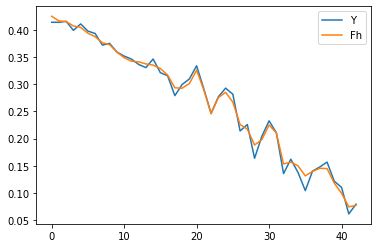

In [76]:
plt.plot(Y, label='Y')
#plt.plot(Fa_1, label='Fa')
plt.plot(Fhat, label='Fh')
plt.legend()
plt.show()